# Konformno predviđanje: NeuralProphet

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

from neuralprophet import NeuralProphet, uncertainty_evaluate, set_log_level, set_random_seed

warnings.filterwarnings("ignore")
set_log_level("ERROR")

c:\Users\Duje\Desktop\fer\6. semestar\lumen\Prediction-of-Hotel-Occupancy\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [2]:
DATA_HOTEL0_BASE_PATH = '../data/interim/hotel_0'
DATA_HOTEL1_BASE_PATH = '../data/interim/hotel_1'

## Učitaj, transformiraj i razdijeli podatke

NeuralProphet zahtijeva da podaci budu u Pandas dataframeu sa stupcima `ds` (vrijeme) i `y` (vrijednosti vremenskog niza). 

In [3]:
NumberOfGuestsDailyResort = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "daily", "daily_guests.parquet"))
NumberOfGuestsDailyCity = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "daily", "daily_guests.parquet"))

NumberOfGuestsDailyResort.reset_index(inplace=True)
NumberOfGuestsDailyResort.drop("prosjecna_cijena_po_osobi", axis="columns", inplace=True)
NumberOfGuestsDailyResort.rename(columns={"ukupno_gostiju": "y", "datum": "ds"}, inplace=True)

NumberOfGuestsDailyCity.reset_index(inplace=True)
NumberOfGuestsDailyCity.drop("prosjecna_cijena_po_osobi", axis="columns", inplace=True)
NumberOfGuestsDailyCity.rename(columns={"ukupno_gostiju": "y", "index": "ds"}, inplace=True)

Podatke dijelimo na skupove za učenje, kalibraciju i testiranje (60%, 20%, 20%) koristeći metodu `NeuralProphet.df_split`. Radimo s podacima na dnevnoj razini pa postavljamo `freq` na `"D"`.

In [4]:
m = NeuralProphet()

resort_train_cal, resort_test = m.split_df(NumberOfGuestsDailyResort, freq="D", valid_p=0.2)
resort_train, resort_cal = m.split_df(resort_train_cal, freq="D", valid_p=0.25)

city_train_cal, city_test = m.split_df(NumberOfGuestsDailyCity, freq="D", valid_p=0.2)
city_train, city_cal = m.split_df(city_train_cal, freq="D", valid_p=0.25)

len(resort_train), len(city_train)

(485, 666)

## Osnovni modeli

In [5]:
models = [
    NeuralProphet(),
    NeuralProphet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
    ),
    NeuralProphet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        n_lags=6,
    ),
    NeuralProphet(
        yearly_seasonality=False,
        weekly_seasonality=True,
        daily_seasonality=False,
        n_lags=6,
    ),
    NeuralProphet(
        yearly_seasonality=False,
        weekly_seasonality=True,
        daily_seasonality=False,
        n_lags=6,
        ar_layers=[20],
    ),
]

for m in models:
    m.set_plotting_backend("plotly-static")

In [6]:
def reproducible_fit(x):
    set_random_seed(0)
    return x.fit(resort_train_cal)

metrics = list(map(reproducible_fit, models))
test_results = [m.test(resort_test) for m in models]
print(test_results)

Finding best initial lr: 100%|██████████| 221/221 [00:01<00:00, 164.68it/s]


Epoch 130: 100%|██████████| 130/130 [00:00<00:00, 1040.00it/s, loss=0.0299, v_num=87, MAE=50.50, RMSE=67.70, Loss=0.0301, RegLoss=0.000]  


Finding best initial lr: 100%|██████████| 221/221 [00:01<00:00, 148.37it/s]


Epoch 130: 100%|██████████| 130/130 [00:00<00:00, 992.39it/s, loss=0.0189, v_num=88, MAE=40.70, RMSE=56.00, Loss=0.019, RegLoss=0.000]    


Finding best initial lr: 100%|██████████| 221/221 [00:01<00:00, 129.84it/s]


Epoch 130: 100%|██████████| 130/130 [00:00<00:00, 909.05it/s, loss=0.00841, v_num=89, MAE=26.90, RMSE=35.60, Loss=0.00841, RegLoss=0.000]   


Finding best initial lr: 100%|██████████| 221/221 [00:01<00:00, 139.21it/s]


Epoch 130: 100%|██████████| 130/130 [00:00<00:00, 928.55it/s, loss=0.00909, v_num=90, MAE=27.70, RMSE=36.80, Loss=0.00909, RegLoss=0.000]   


Finding best initial lr: 100%|██████████| 221/221 [00:02<00:00, 108.53it/s]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.25370243191719055
         MAE_val             172.6878204345703
        RMSE_val            184.49276733398438
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
──────────────────────────────────────────────────────────────────────────────────────────────────────────

In [7]:
test_results_mae = np.array([result["MAE_val"] for result in test_results]).flatten()
best_model_idx = np.argmin(test_results_mae)
print(f"Best model: {best_model_idx}")
test_results[best_model_idx]

Best model: 3


,MAE_val,RMSE_val,Loss_test,RegLoss_test
0,25.49217,34.957382,0.010813,0.0


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.96it/s]


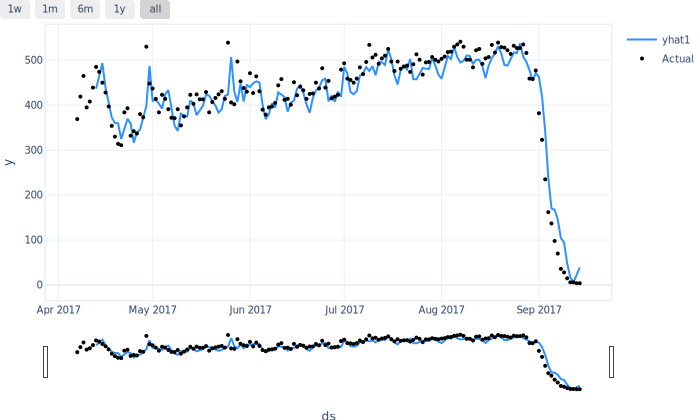

In [8]:
forecast = models[best_model_idx].predict(resort_test) # NOTE: AR-nets produce only a one-step-ahead prediction
models[best_model_idx].plot(forecast)

### Performanse svih naučenih modela na skupu za učenje i kalibraciju

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.64it/s]

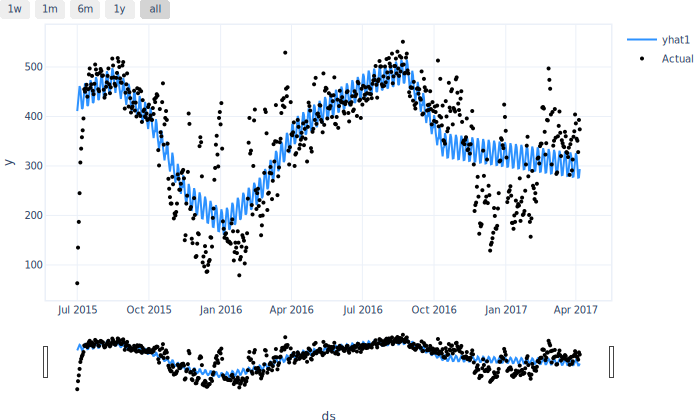

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.37it/s]


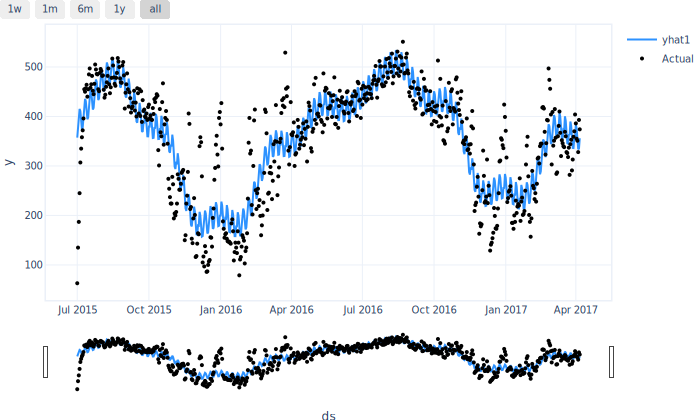

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.04it/s]


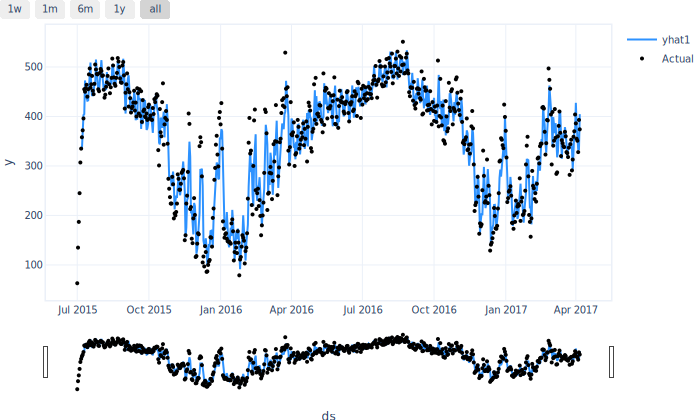

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.07it/s]


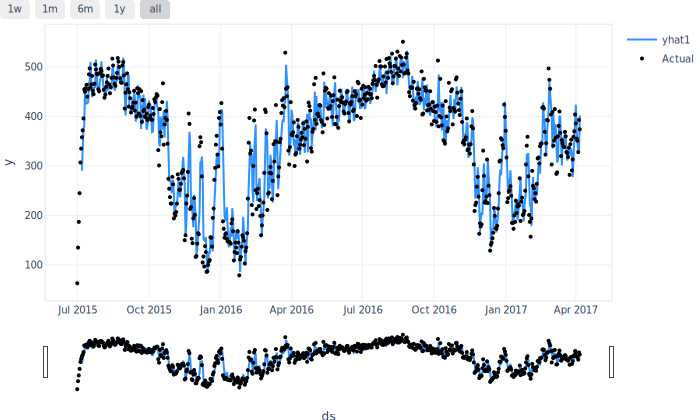

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.47it/s]


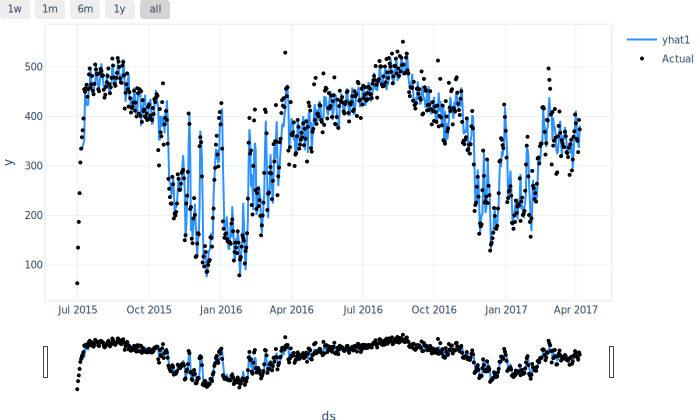

In [9]:
for m in models:
    f = m.predict(resort_train_cal)
    m.plot(f)

## Predviđanje više koraka u budućnost

In [10]:
future_model = NeuralProphet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags=6,
    n_forecasts=30,
)

future_model.set_plotting_backend("plotly-static")

set_random_seed(0)
metrics = future_model.fit(resort_train_cal)
future_model.test(resort_test)

Finding best initial lr: 100%|██████████| 221/221 [00:02<00:00, 83.70it/s] 


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.19424588978290558
         MAE_val             143.0465545654297
        RMSE_val             157.8494110107422
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE_val,RMSE_val,Loss_test,RegLoss_test
0,143.046555,157.849411,0.194246,0.0


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.46it/s]

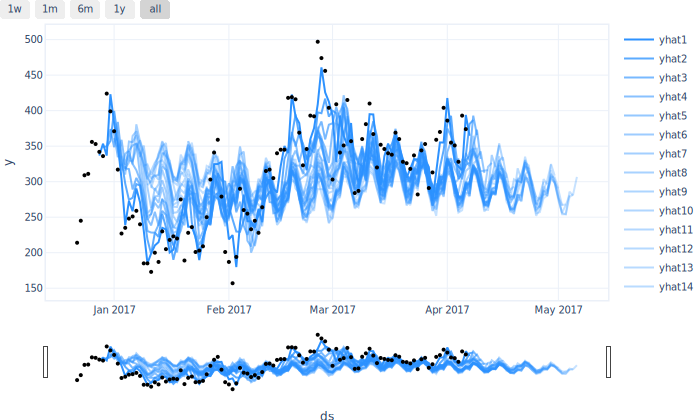

In [11]:
future = future_model.make_future_dataframe(resort_train_cal, periods=30, n_historic_predictions=100)
forecast = future_model.predict(future)

future_model.plot(forecast)

## Kvantilna regresija

In [12]:
confidence_lv = 0.9
quantile_list = [round(((1 - confidence_lv) / 2), 2), round((confidence_lv + (1 - confidence_lv) / 2), 2)]
n_lags = 6

quantile_list

[0.05, 0.95]

In [13]:
qr_model = NeuralProphet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags=n_lags,
    quantiles=quantile_list,
)
qr_model.set_plotting_backend("plotly-static")

set_random_seed(0)
metrics = qr_model.fit(resort_train_cal)
qr_model.test(resort_test)

Finding best initial lr:   3%|▎         | 6/221 [00:00<00:03, 54.84it/s]

Finding best initial lr: 100%|██████████| 221/221 [00:02<00:00, 74.70it/s]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.015867099165916443
         MAE_val            24.271602630615234
        RMSE_val            34.140254974365234
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE_val,RMSE_val,Loss_test,RegLoss_test
0,24.271603,34.140255,0.015867,0.0


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.20it/s]

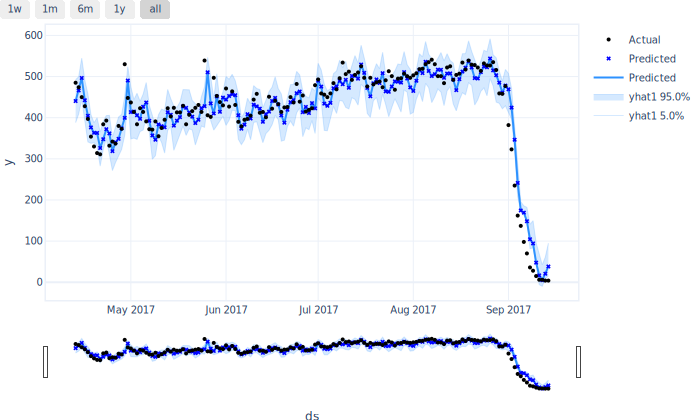

yhat1                 
  interval_width miscoverage_rate
0      85.723358              0.2

In [14]:
forecast = qr_model.predict(resort_test)[n_lags:]
qr_model.highlight_nth_step_ahead_of_each_forecast(1).plot(forecast)
uncertainty_evaluate(forecast)

## Konformni modeli

### _naive_

In [15]:
naive_model = NeuralProphet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags=n_lags,
    quantiles=quantile_list,
)

set_random_seed(0)
metrics = naive_model.fit(resort_train)

Finding best initial lr:   0%|          | 0/219 [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 219/219 [00:02<00:00, 95.80it/s] 


Epoch 140: 100%|██████████| 140/140 [00:00<00:00, 818.75it/s, loss=0.0126, v_num=94, MAE=27.70, RMSE=37.90, Loss=0.0126, RegLoss=0.000]  


In [16]:
naive_forecast = naive_model.conformal_predict(
    resort_test,
    calibration_df=resort_cal,
    alpha=1 - confidence_lv,
    method="naive",
    plotting_backend="plotly-static",
    show_all_PI=True,
)

naive_model.highlight_nth_step_ahead_of_each_forecast(1).plot(naive_forecast)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.02it/s] 


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.39it/s]


ERROR - (NP.plotly.plot) - plotly-resampler is not installed. Please install it to use the resampler.


In [17]:
uncertainty_evaluate(naive_forecast)

yhat1                 
  interval_width miscoverage_rate
0     130.776062         0.077419

### CQR

In [18]:
cqr_model = NeuralProphet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags=n_lags,
    quantiles=quantile_list,
)

set_random_seed(0)
metrics = cqr_model.fit(resort_train)

Finding best initial lr:   0%|          | 0/219 [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 219/219 [00:02<00:00, 89.92it/s]


Epoch 140: 100%|██████████| 140/140 [00:00<00:00, 786.50it/s, loss=0.0126, v_num=95, MAE=27.70, RMSE=37.90, Loss=0.0126, RegLoss=0.000]  


In [19]:
cqr_forecast = cqr_model.conformal_predict(
    resort_test,
    calibration_df=resort_cal,
    alpha=1 - confidence_lv,
    method="cqr",
    plotting_backend="plotly-static",
    show_all_PI=True,
)

cqr_model.highlight_nth_step_ahead_of_each_forecast(1).plot(cqr_forecast)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.91it/s] 


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.46it/s] 


ERROR - (NP.plotly.plot) - plotly-resampler is not installed. Please install it to use the resampler.


In [20]:
uncertainty_evaluate(cqr_forecast)

yhat1                 
  interval_width miscoverage_rate
0     210.086487         0.058065

### CQR s dubokim modelom AR-Net

In [21]:
cqr_deep_model = NeuralProphet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags=n_lags,
    quantiles=quantile_list,
    ar_layers=[20],
)

set_random_seed(0)
metrics = cqr_deep_model.fit(resort_train)

Finding best initial lr:   3%|▎         | 6/219 [00:00<00:03, 58.25it/s]

Finding best initial lr: 100%|██████████| 219/219 [00:02<00:00, 86.09it/s]


Epoch 140: 100%|██████████| 140/140 [00:00<00:00, 769.24it/s, loss=0.0136, v_num=96, MAE=30.00, RMSE=40.50, Loss=0.0136, RegLoss=0.000]  


In [22]:
cqr_deep_forecast = cqr_deep_model.conformal_predict(
    resort_test,
    calibration_df=resort_cal,
    alpha=1 - confidence_lv,
    method="cqr",
    plotting_backend="plotly-static",
    show_all_PI=True,
)

cqr_deep_model.highlight_nth_step_ahead_of_each_forecast(1).plot(cqr_deep_forecast)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.89it/s] 


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.87it/s] 


ERROR - (NP.plotly.plot) - plotly-resampler is not installed. Please install it to use the resampler.


In [23]:
uncertainty_evaluate(cqr_deep_forecast)

yhat1                 
  interval_width miscoverage_rate
0     204.681335         0.032258

## Unakrsna provjera

In [24]:
METRICS = ["MAE", "RMSE"]
METRICS_VAL = ["MAE_val", "RMSE_val"]

cross_val_qr_model = NeuralProphet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags=n_lags,
    quantiles=quantile_list,
)

folds = cross_val_qr_model.crossvalidation_split_df(NumberOfGuestsDailyResort, freq="MS", k=5, fold_pct=0.20, fold_overlap_pct=0.5) 

In [25]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_test = pd.DataFrame(columns=METRICS_VAL)

for i, (df_train, df_test) in enumerate(folds):
    m = NeuralProphet(
        yearly_seasonality=False,
        weekly_seasonality=True,
        daily_seasonality=False,
        n_lags=n_lags,
        quantiles=quantile_list,
    )

    m.set_plotting_backend("plotly-static")

    set_random_seed(0)
    train = m.fit(df=df_train, freq="MS")
    test = m.test(df=df_test)

    metrics_train.loc[i] = train[METRICS].iloc[-1]
    metrics_test.loc[i] = test[METRICS_VAL].iloc[-1]

Finding best initial lr:   3%|▎         | 6/215 [00:00<00:03, 56.09it/s]

Finding best initial lr: 100%|██████████| 215/215 [00:02<00:00, 106.68it/s]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.06432266533374786
         MAE_val             32.92771530151367
        RMSE_val            42.313682556152344
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Finding best initial lr: 100%|██████████| 217/217 [00:01<00:00, 120.07it/s]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.66it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.12895646691322327
         MAE_val             37.12495040893555
        RMSE_val             46.09587097167969
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Finding best initial lr: 100%|██████████| 219/219 [00:02<00:00, 98.66it/s] 


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.017480414360761642
         MAE_val             28.1680850982666
        RMSE_val             36.63899612426758
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Finding best initial lr: 100%|██████████| 220/220 [00:02<00:00, 94.97it/s] 


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.022487051784992218
         MAE_val             27.5317440032959
        RMSE_val            36.037010192871094
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Finding best initial lr: 100%|██████████| 221/221 [00:02<00:00, 100.22it/s]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.01643809676170349
         MAE_val             24.8201961517334
        RMSE_val             34.45755386352539
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [26]:
metrics_test.describe().loc[["mean", "std", "min", "max"]]

,MAE_val,RMSE_val
mean,30.114538,39.108623
std,4.887469,4.905618
min,24.820196,34.457554
max,37.124950,46.095871


## City dataset, kvantilna regresija

In [27]:
city_model = NeuralProphet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags=n_lags,
    quantiles=quantile_list,
)
city_model.set_plotting_backend("plotly-static")

set_random_seed(0)
metrics = city_model.fit(city_train_cal)
city_model.test(city_test)

Finding best initial lr:   3%|▎         | 6/224 [00:00<00:03, 54.55it/s]

Finding best initial lr: 100%|██████████| 224/224 [00:02<00:00, 84.57it/s]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.006948402617126703
         MAE_val             25.43002700805664
        RMSE_val            34.694915771484375
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE_val,RMSE_val,Loss_test,RegLoss_test
0,25.430027,34.694916,0.006948,0.0


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.02it/s]


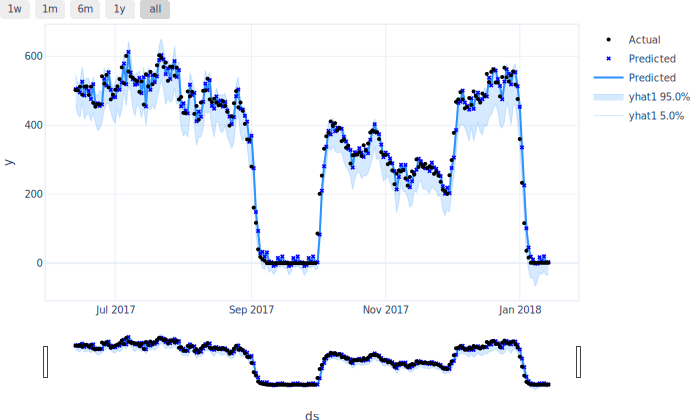

yhat1                 
  interval_width miscoverage_rate
0       79.15509         0.314815

In [28]:
forecast = city_model.predict(city_test)[n_lags:]
city_model.highlight_nth_step_ahead_of_each_forecast(1).plot(forecast)
uncertainty_evaluate(forecast)